In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
import keras
from IPython.display import clear_output
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from sklearn.metrics import confusion_matrix
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
import pickle
import os

Using TensorFlow backend.


In [2]:
trainPath = '../PFR_Data/train/'
testPath = '../PFR_Data/test/'
valPath = '../PFR_Data/vald'

PFR_NUM_CLASS = 10
FUEL_TYPE_NUM_CLASS = 5
BATCH_SIZE = 128
EPOCHS =50

In [3]:
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [15]:
def  plot_train_history(history,N,path):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].plot(history.history['loss'], label='PFR Train Loss')
    axes[0].plot(history.history['val_loss'], label='PFR Val Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['accuracy'], label='FT Train accuracy')
    axes[1].plot(history.history['val_accuracy'], label='FT Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    
    plt.savefig(path)

## Augmentation

In [5]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator('''
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"''')
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

## Generator

In [6]:
# initialize the training generator
img_size = 224
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(img_size, img_size),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(img_size, img_size),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(img_size, img_size),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 7484 images belonging to 10 classes.
Found 1591 images belonging to 10 classes.
Found 1591 images belonging to 10 classes.


## Model

In [8]:
baseModel =  pickle.load(open('../Models/VGG16.sav', 'rb'))

C:\Users\z0045jzp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(img_size, img_size, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(PFR_NUM_CLASS, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [10]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(trainGen.classes), 
                trainGen.classes)
class_weights

array([0.18511007, 2.06740331, 1.00321716, 3.53018868, 2.48637874,
       2.27477204, 1.57557895, 6.68214286, 1.04233983, 4.02365591])

In [11]:
checkpoint_template = os.path.join('../Models/PFRModel/checkpoint/', "pfrNet_{epoch:03d}_{val_loss:.2f}.hdf5")
checkpoint = ModelCheckpoint('../Models/PFRModel/checkpoint/PFRModel.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto',period=5)
callbacks_list = [checkpoint]

In [13]:
# compile our model (this needs to be done after our setting our layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-5, momentum=0.8)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
#initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit_generator(
    trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=100,
    class_weight=class_weights)
# reset the testing generator and evaluate the network after
# fine-tuning just the network head

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
58/58 [==============================] - 92s 2s/step - loss: 6.9235 - accuracy: 0.3866 - val_loss: 6.7779 - val_accuracy: 0.6387
Epoch 2/100
58/58 [==============================] - 85s 1s/step - loss: 3.8298 - accuracy: 0.5517 - val_loss: 7.6744 - val_accuracy: 0.6815
Epoch 3/100
58/58 [==============================] - 84s 1s/step - loss: 2.9578 - accuracy: 0.5772 - val_loss: 2.8854 - val_accuracy: 0.7300
Epoch 4/100
58/58 [==============================] - 80s 1s/step - loss: 2.4182 - accuracy: 0.5993 - val_loss: 3.4892 - val_accuracy: 0.6938
Epoch 5/100
58/58 [==============================] - 78s 1s/step - loss: 1.9540 - accuracy: 0.6461 - val_loss: 1.7562 - val_accuracy: 0.7327
Epoch 6/100
58/58 [==============================] - 87s 2s/step - loss: 1.5950 - accuracy: 0.6660 - val_loss: 0.6209 - val_accuracy: 0.7307
Epoch 7/100
58/58 [==============================] - 77s 1s/step - loss: 1.3504 - accuracy: 0.6932 - val

58/58 [==============================] - 67s 1s/step - loss: 0.2860 - accuracy: 0.8948 - val_loss: 0.3299 - val_accuracy: 0.8483
Epoch 59/100
58/58 [==============================] - 68s 1s/step - loss: 0.2797 - accuracy: 0.8998 - val_loss: 0.0095 - val_accuracy: 0.8407
Epoch 60/100
58/58 [==============================] - 67s 1s/step - loss: 0.2636 - accuracy: 0.9067 - val_loss: 0.0125 - val_accuracy: 0.8298
Epoch 61/100
58/58 [==============================] - 77s 1s/step - loss: 0.2812 - accuracy: 0.8976 - val_loss: 0.0218 - val_accuracy: 0.8319
Epoch 62/100
58/58 [==============================] - 73s 1s/step - loss: 0.2580 - accuracy: 0.9077 - val_loss: 4.5746e-04 - val_accuracy: 0.8346
Epoch 63/100
58/58 [==============================] - 75s 1s/step - loss: 0.2645 - accuracy: 0.9077 - val_loss: 0.0060 - val_accuracy: 0.8339
Epoch 64/100
58/58 [==============================] - 73s 1s/step - loss: 0.2701 - accuracy: 0.8994 - val_loss: 0.0057 - val_accuracy: 0.8353
Epoch 65/100
58

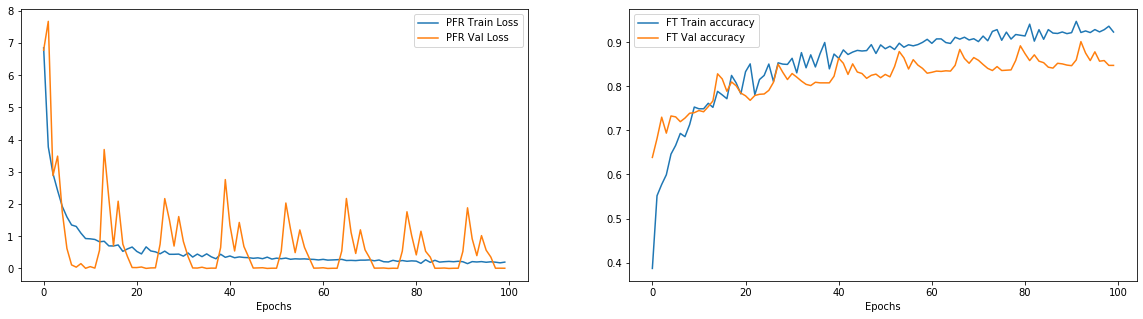

In [16]:
plot_train_history(H, 100, '../PFRIndv/pfrTrain.png')

In [17]:
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
    steps=(totalTest // BATCH_SIZE) + 1)
predIdxsClasses = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxsClasses,
    target_names=testGen.class_indices.keys()))

[INFO] evaluating after fine-tuning network head...
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       865
         1-3       0.79      0.45      0.57        76
       10-12       0.68      0.94      0.79       158
       13-15       0.57      0.27      0.37        44
       20-25       0.71      0.78      0.74        63
       30-40       0.78      0.90      0.84        69
         4-5       0.69      0.66      0.68       101
       41-56       1.00      0.78      0.88        23
         6-9       0.81      0.48      0.60       153
         60+       0.83      0.90      0.86        39

    accuracy                           0.85      1591
   macro avg       0.78      0.71      0.73      1591
weighted avg       0.85      0.85      0.84      1591



In [18]:
labs = testGen.class_indices.keys()
PFRLabels = []
for lab in labs:
    PFRLabels.append(lab)
PFRLabels

['0', '1-3', '10-12', '13-15', '20-25', '30-40', '4-5', '41-56', '6-9', '60+']

In [19]:
cm = confusion_matrix(testGen.classes, predIdxsClasses)
cm = pd.DataFrame(cm)
cm.columns = PFRLabels
cm.index = PFRLabels
cm

,0,1-3,10-12,13-15,20-25,30-40,4-5,41-56,6-9,60+
0,860,0,4,0,0,0,1,0,0,0
1-3,20,34,13,0,0,0,1,0,7,1
10-12,0,1,148,3,4,0,0,0,2,0
13-15,2,0,19,12,7,2,1,0,1,0
20-25,3,0,2,3,49,5,0,0,1,0
30-40,0,0,0,0,3,62,0,0,0,4
4-5,17,6,4,0,0,0,67,0,6,1
41-56,0,0,0,0,0,5,0,18,0,0
6-9,11,2,29,3,5,2,27,0,73,1
60+,0,0,0,0,1,3,0,0,0,35


In [ ]:
WARMUP_PLOT_PATH = '../Models/PFRModel/train.png'
plot_training(H, EPOCHS, WARMUP_PLOT_PATH)

In [ ]:
pickle.dump(model, open('../Models/PFRModel/PFRModel.sav', 'wb'))